# Introduction

This lab is a step-by-step tutorial on how to perform Gaussian Process Regression (GPR) on Mauna Loa CO2 data using the scikit-learn package. The data consists of monthly average atmospheric CO2 concentrations collected at the Mauna Loa Observatory in Hawaii between 1958 and 2001. The objective is to model the CO2 concentration as a function of time and extrapolate it for years after 2001.

# Build the Dataset

The first step is to build the dataset by deriving it from the Mauna Loa Observatory that collected air samples. We are interested in estimating the concentration of CO2 and extrapolate it for further years. We load the original dataset available in OpenML and preprocess the dataset by taking a monthly average and dropping months for which no measurements were collected.

In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")

X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

/var/folders/xl/cw1gsh4s5398kfn_9w27_tmc0000gn/T/ipykernel_81169/419368932.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")


# Design the Proper Kernel

To design the kernel to use with our Gaussian process, we can make some assumption regarding the data at hand. We observe that they have several characteristics: we see a long term rising trend, a pronounced seasonal variation, and some smaller irregularities. We can use different appropriate kernel that would capture these features.

In [2]:
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)
seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)
irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)
noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)

# Model Fitting and Extrapolation

Now, we are ready to use a Gaussian process regressor and fit the available data. To follow the example from the literature, we will subtract the mean from the target. We create synthetic data from 1958 to the current month and use the Gaussian process to predict on training data to inspect the goodness of fit and future data to see the extrapolation done by the model.

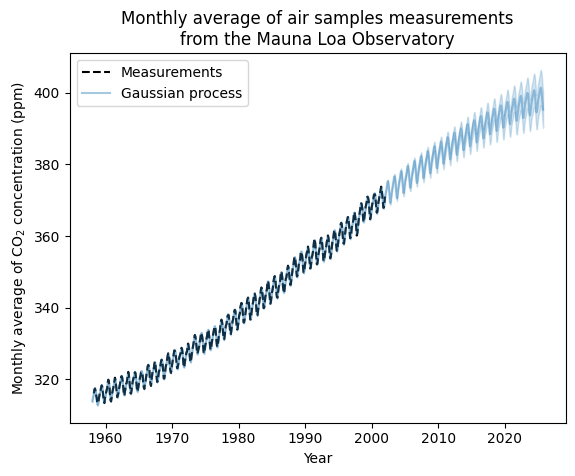

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
import datetime
import numpy as np
import matplotlib.pyplot as plt

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)
plt.show()

# Interpretation of Kernel Hyperparameters

Now, we can have a look at the hyperparameters of the kernel.

In [4]:
gaussian_process.kernel_

44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)

Thus, most of the target signal, with the mean subtracted, is explained by a long-term rising trend for ~45 ppm and a length-scale of ~52 years. The periodic component has an amplitude of ~2.6ppm, a decay time of ~90 years and a length-scale of ~1.5. The long decay time indicates that we have a component very close to a seasonal periodicity. The correlated noise has an amplitude of ~0.2 ppm with a length scale of ~0.12 years and a white-noise contribution of ~0.04 ppm. Thus, the overall noise level is very small, indicating that the data can be very well explained by the model.

# Summary

This lab demonstrated how to perform Gaussian Process Regression (GPR) on Mauna Loa CO2 data using the scikit-learn package. The data consists of monthly average atmospheric CO2 concentrations collected at the Mauna Loa Observatory in Hawaii between 1958 and 2001. The objective is to model the CO2 concentration as a function of time and extrapolate it for years after 2001. We built the dataset, designed the proper kernel, fitted the model, and performed extrapolation. Finally, we interpreted the kernel hyperparameters.